In [1]:
import pandas as pd
import numpy as np 
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


读取数据（取最小行数）

In [2]:
datalist = []
min_rows = float('inf') 

for filename in sorted(os.listdir("/home/yichuan/ywc/meta-labeling/cryptocurrency")):
    if filename.endswith('.csv'):
        file_path = os.path.join("/home/yichuan/ywc/meta-labeling/cryptocurrency", filename)
        print(filename)
        df = pd.read_csv(file_path)
        df = df.drop(columns=["Date"])
        datalist.append(df.values)
        min_rows = min(min_rows, df.shape[0])      

data_list = [data[-min_rows:] for data in datalist]

print(min_rows,len(data_list))

BTC-USD_historical_data.csv
ETH-USD_historical_data.csv
LTC-USD_historical_data.csv
XRP-USD_historical_data.csv
1878 4


处理最后一列

In [3]:
def logVolume(X: np.ndarray):
    volume = X[:, -1]  
    volume_log = np.log(volume + 1)  

    mean_log = np.mean(volume_log)  
    std_log = np.std(volume_log)  

    volume_std = (volume_log - mean_log) / std_log  

    X[:, -1] = volume_std  

    return X


for data in data_list:
    data=logVolume(data)    

print(data_list[0])

[[ 7.44683008e+03  7.44683008e+03  7.10152002e+03  7.14358008e+03
   7.14358008e+03 -2.14055785e+00]
 [ 7.17372998e+03  7.31200000e+03  6.43687012e+03  6.61814014e+03
   6.61814014e+03 -1.56919547e+00]
 [ 6.61860986e+03  6.87314990e+03  6.20422021e+03  6.35760010e+03
   6.35760010e+03 -1.63986817e+00]
 ...
 [ 1.67164004e+04  1.67681699e+04  1.64975566e+04  1.65525723e+04
   1.65525723e+04 -1.57495316e-01]
 [ 1.65523223e+04  1.66517559e+04  1.65086836e+04  1.66423418e+04
   1.66423418e+04 -3.49949060e-01]
 [ 1.66413301e+04  1.66434277e+04  1.64084746e+04  1.66025859e+04
   1.66025859e+04 -2.35515844e-01]]


创建标签函数

In [4]:

days=10

ptsl = [0.05, 0.05]  
return_min = 0.005
def triple_barrier(close: np.ndarray, days=10, pts=[0.05, 0.05] ):
    bin = np.zeros(close.size, dtype=int)  
    for i in range(close.size):
        for d in range(days):
            index = min(i + d + 1, close.size - 1)  
            if close[index] >= close[i] * (1 + ptsl[0]):  
                bin[i] = 1
                break
            elif close[index] <= close[i] * (1 - ptsl[1]):  
                bin[i] = -1
                break
    
    return bin




In [5]:
binmat=np.full((min_rows, 4), 3)
for i in range(4):
    binmat[:,i]=triple_barrier(data_list[i][:,3])


print(binmat)

[[-1 -1 -1 -1]
 [-1  1  1  1]
 [-1  1 -1 -1]
 ...
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


Generate Continuous Signal 

In [6]:
lmbda = 0.5
label_mat=np.full((min_rows, 4), 3.10)
alpha = 0.5
for j in range(4):
    y_sm = np.full(min_rows, 3.10)
    y_so = np.full(min_rows, 3.10)

    for i in range(min_rows):
        if i == 0:
            y_sm[i] = 1
        else:
            y_sm[i] = lmbda*binmat[i,j] + (1-lmbda)*y_sm[i-1]
    #print("smooth:",y_sm)
    
    
    for i in range(min_rows):
        X_train = np.delete(data_list[j], i, axis=0)
        y_train = np.delete(binmat[:,j], i, axis=0)
        x_test = data_list[j][i,:]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        x_test_scaled = scaler.transform(x_test.reshape(1, -1))

        modelL = LogisticRegression(
           solver="lbfgs",                     
           max_iter=1000
        )
        modelL.fit(X_train_scaled, y_train)

        prob = modelL.predict_proba(x_test_scaled)
        class_labels = modelL.classes_
        y_so[i] = np.sum(class_labels * prob[0])

    label_mat[:,j] = alpha*y_sm + (1-alpha)*y_so
    #print("soft:",y_so)
    
label_mat = (label_mat+1)/2
print("Label mat:",label_mat)
         
    


Label mat: [[0.74683294 0.71016482 0.74736707 0.73601524]
 [0.5066391  0.70917091 0.75425395 0.73556469]
 [0.38055628 0.70642653 0.49655695 0.48684046]
 ...
 [0.51514612 0.49383441 0.48494751 0.41423019]
 [0.51167959 0.48558761 0.48453196 0.45357824]
 [0.51379837 0.4851224  0.48810349 0.46756444]]


合并 Merge

In [7]:
# 确保所有二维数组具有相同的形状
shapes = {data.shape for data in data_list}
if len(shapes) > 1:
    raise ValueError("所有 CSV 文件中的数据形状必须一致")
    
dataset=np.array(data_list)
print(dataset.shape)
dataset = dataset.transpose(1, 0, 2).reshape(1878, -1)
print(dataset.shape)

(4, 1878, 6)
(1878, 24)


Primary model with constraints

In [8]:
def primary_model(j, train_ratio):
    X = np.array(data_list[j])
    targets=label_mat[:,j]
    n_train = int(len(X) * train_ratio) 
    X_train = X[:n_train]
    X_test = X[n_train:]
    y_train = targets[:n_train]
    y_test = targets[n_train:]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    params = {
        "objective": "reg:logistic",  
        "eval_metric": "rmse",        
        "learning_rate": 0.1,
        "max_depth": 3,
        "subsample": 0.8
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=100)
    
    y_pred_primary = model.predict(dtest)
    
    return y_pred_primary




Secondary model (meta-labeling)

In [9]:
# Step 3: Develop secondary model (meta-labeling) 二级模型，即meta-labeling
# Create meta-labels for secondary model training


class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 1) 
        )

    def forward(self, x):
        return self.net(x)

def custom_loss(outputs, targets, model, lambda_l2):
    mse_loss = nn.MSELoss()(outputs, targets)
    l2_reg = sum(p.pow(2).sum() for p in model.parameters())
    return mse_loss + lambda_l2 * l2_reg

def secondary_model(j, primary_signals, train_ratio, threshold, lambda_l2=1e-5):
    targets = label_mat[:, j]
    X = np.array(data_list[j])

    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    
    n_train = int(len(X) * train_ratio)
    X_test = X[n_train:]
    y_test = targets[n_train:]
    
    
    meta_labels = y_test - primary_signals

    
    t_indices = np.arange(len(X_test))

    
    X_tensor = torch.tensor(X_test, dtype=torch.float32)
    meta_tensor = torch.tensor(meta_labels, dtype=torch.float32).view(-1, 1)

    
    X_train_meta, X_test_meta, y_train_meta, y_test_meta, t_indices_train, t_indices_test = train_test_split(
        X_tensor, meta_tensor, t_indices, test_size=0.5, random_state=42
    )
    print("y_test_meta:", y_test_meta.shape)

    
    model2 = RegressionNN(input_dim=X_test.shape[1])
    optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.001)
    num_epochs = 1000
    batch_size = 32
    train_losses = []

    
    for epoch in range(num_epochs):
        permutation = torch.randperm(X_train_meta.size(0))
        for i in range(0, X_train_meta.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X = X_train_meta[indices]
            batch_y = y_train_meta[indices]

            outputs = model2(batch_X)
            loss = custom_loss(outputs, batch_y, model2, lambda_l2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            train_pred = model2(X_train_meta)
            train_loss = custom_loss(train_pred, y_train_meta, model2, lambda_l2)
            train_losses.append(train_loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}')

    
    with torch.no_grad():
        model2.eval()
        test_pred = model2(X_test_meta)
        test_loss = custom_loss(test_pred, y_test_meta, model2, lambda_l2)

        y_test_np = y_test_meta.numpy().flatten()
        pred_np = test_pred.numpy().flatten()

        print(f'\nFinal Test Loss: {test_loss.item():.4f}')
        print("\n样例预测对比：")
        print("真实值 | 预测值")
        for true, pred in zip(y_test_np[:10], pred_np[:10]):
            print(f"{true:.4f} | {pred:.4f} 差 {abs(true-pred):.4f}")

    
    refined_signals = primary_signals.copy()
    large_deviation_mask = (np.abs(pred_np) > threshold)
    meta_large_indices = np.where(large_deviation_mask)[0]
    original_test_indices = t_indices_test[meta_large_indices]

    for idx in original_test_indices:
        refined_signals[idx] = refined_signals[idx] + pred_np[np.where(t_indices_test == idx)[0][0]]

    print("meta_labels 均值：", meta_labels.mean())
    #plt.hist(meta_labels, bins=20)
    #plt.title("Meta Labels Distribution")
    #plt.show()

    return refined_signals







In [10]:
train_ratio = 0.8
n_train = int(len(np.array(data_list[0])) * train_ratio) 
n_test  = len(np.array(data_list[0])) - n_train
primary_signals = np.full((n_test,4),3.0)
Refined_signals = np.full((n_test,4),3.0)

for i in range(4):
    primary_signals[:,i] = primary_model(i, train_ratio)
    Refined_signals[:,i] = secondary_model(i,primary_signals[:,i], train_ratio, threshold=0.25)

print("primary_signals", primary_signals)
print("Refined_signals", Refined_signals)



y_test_meta: torch.Size([188, 1])
Epoch [100/1000], Loss: 0.0323
Epoch [200/1000], Loss: 0.0306
Epoch [300/1000], Loss: 0.0275
Epoch [400/1000], Loss: 0.0272
Epoch [500/1000], Loss: 0.0287
Epoch [600/1000], Loss: 0.0285
Epoch [700/1000], Loss: 0.0269
Epoch [800/1000], Loss: 0.0287
Epoch [900/1000], Loss: 0.0267
Epoch [1000/1000], Loss: 0.0280

Final Test Loss: 0.0286

样例预测对比：
真实值 | 预测值
-0.2472 | -0.1775 差 0.0697
-0.0395 | -0.0469 差 0.0074
0.1676 | -0.1124 差 0.2800
0.0613 | -0.2024 差 0.2637
-0.0518 | -0.1428 差 0.0910
0.2641 | 0.0073 差 0.2568
-0.1521 | 0.0102 差 0.1623
-0.1414 | -0.0648 差 0.0766
0.2083 | 0.0975 差 0.1108
-0.0460 | 0.0462 差 0.0922
meta_labels 均值： -0.10307498060518798
y_test_meta: torch.Size([188, 1])
Epoch [100/1000], Loss: 0.0328
Epoch [200/1000], Loss: 0.0316
Epoch [300/1000], Loss: 0.0317
Epoch [400/1000], Loss: 0.0305
Epoch [500/1000], Loss: 0.0294
Epoch [600/1000], Loss: 0.0304
Epoch [700/1000], Loss: 0.0295
Epoch [800/1000], Loss: 0.0297
Epoch [900/1000], Loss: 0.0295

In [11]:
not_equal = primary_signals != Refined_signals
refined_num = np.sum(not_equal, axis=0)
print("refined number:", refined_num)

error1 = (primary_signals < 0) | (primary_signals > 1)
error2 = (Refined_signals < 0) | (Refined_signals > 1)
print("errors:",np.sum(error1),np.sum(error2))

refined number: [18  9  0  2]
errors: 0 0


Generate modified(final) portfolio 

In [12]:
def asset_exposure_constraint(weights, max_exposure):
    """Ensure no asset weight exceeds max_exposure."""
    return all(abs(w) <= max_exposure for w in weights)

def sector_diversification_constraint(weights, sector_mapping, min_sectors):
    """Ensure allocation spans at least min_sectors."""
    unique_sectors = set(sector_mapping[np.nonzero(weights)])
    return len(unique_sectors) >= min_sectors


def risk_tolerance_constraint(weights, cov_matrix, max_risk):
    """Ensure portfolio variance is within max_risk."""
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    #print(portfolio_variance)
    return portfolio_variance <= max_risk

def apply_constraints(weights, sector_mapping, cov_matrix):
    """Check all constraints."""
    return (
        asset_exposure_constraint(weights, max_exposure=0.4) and
        sector_diversification_constraint(weights, sector_mapping, min_sectors=2) and
        risk_tolerance_constraint(weights, cov_matrix, max_risk=0.01)
    )

In [13]:
# Assume asset returns, sector mapping, and covariance matrix as placeholders
sector_mapping = np.array([1,2,3,4])

Closemat=np.zeros((min_rows, 4))
for i in range(4):
    Closemat[:,i]=data_list[i][:,3]

Close_test=Closemat[:n_train,:]
print(Close_test.shape, Close_test)
returns = np.log(Close_test[1:] / Close_test[:-1])
cov_matrix = np.cov(returns, rowvar=False)  # rowvar=False 表示按列变量（资产）
print("cov_matrix:",cov_matrix)

asset_returns = np.random.normal(0.01, 0.02, size=dataset.shape[1])



(1502, 4) [[7.14358008e+03 3.20884003e+02 6.42696991e+01 2.17488006e-01]
 [6.61814014e+03 2.99252991e+02 5.92601013e+01 2.06483006e-01]
 [6.35760010e+03 3.14681000e+02 6.23032990e+01 2.10429996e-01]
 ...
 [4.62021445e+04 3.87948657e+03 1.44338409e+02 7.99291015e-01]
 [4.68487773e+04 3.96086011e+03 1.48801407e+02 8.27378988e-01]
 [4.67070156e+04 3.92259253e+03 1.53077637e+02 8.35033000e-01]]
cov_matrix: [[0.00174932 0.0017045  0.00181776 0.00151384]
 [0.0017045  0.00278889 0.00249872 0.00227064]
 [0.00181776 0.00249872 0.00332825 0.00241724]
 [0.00151384 0.00227064 0.00241724 0.00456556]]


In [14]:
# Create a sample portfolio based on signals
def construct_portfolio(signals, asset_returns, sector_mapping, cov_matrix):
    """Construct a portfolio based on signals and constraints."""
    weights = signals.copy()
    row_sums = weights.sum(axis=1, keepdims=True)
    weights = weights / row_sums

    # Apply constraints
    count = 0
    for i in range(len(signals)):
        if apply_constraints(weights[i,:], sector_mapping, cov_matrix) or i == 0:
            weights[i,:] = weights[i,:]
            #print("Constraints good.")
        else:
            #print(weights[i,:])
            weights[i,:] = weights[i-1,:] #adjust weights
            count += 1                
            #print("Constraints not satisfied. Adjust weights.")

    print("Number of days that do not satisfy the constraints:",count)                

    return weights   

In [15]:
final_portfolio_weights = construct_portfolio(Refined_signals, asset_returns, sector_mapping, cov_matrix)
primary_portfolio_weights = construct_portfolio(primary_signals, asset_returns, sector_mapping, cov_matrix)
print("final_portfolio_weight:",final_portfolio_weights, final_portfolio_weights.shape)
#print(primary_portfolio_weights)

Number of days that do not satisfy the constraints: 2
Number of days that do not satisfy the constraints: 0
final_portfolio_weight: [[0.263107   0.2211795  0.26912189 0.24659161]
 [0.24448249 0.23228899 0.2913026  0.23192593]
 [0.26175786 0.24026814 0.26405757 0.23391644]
 ...
 [0.27640408 0.28008388 0.24268878 0.20082326]
 [0.26737543 0.27010479 0.26346782 0.19905195]
 [0.26358776 0.26815422 0.26781652 0.2004415 ]] (376, 4)


Evaluate the performance of the portfolio

In [16]:
def calculate_sharpe_ratio(folder_path, weights, m, n,risk_free_rate=0.0):
    
    files = sorted(os.listdir(folder_path))  
    
    
    stock_data = []
    file_names = []
    for file in files:
        df = pd.read_csv(os.path.join(folder_path, file)).iloc[m:n]        
        stock_data.append(df['Close'].values)
        file_names.append(file)

    #output = []
    #for i, file in enumerate(file_names):
        #output.append(f"{i},{file}")
    #print(", ".join(output))

    stock_prices = np.column_stack(stock_data)

    stock_returns = np.diff(stock_prices, axis=0) / stock_prices[:-1]

    portfolio_returns = np.sum(stock_returns * weights, axis=1)  

    mean_return = np.mean(portfolio_returns) * 365
    volatility = np.std(portfolio_returns) * np.sqrt(365)

    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    return sharpe_ratio


folder_path = "/home/yichuan/ywc/meta-labeling/cryptocurrency"
m = n_train - 1
n = min_rows  

OneN = 0.25 * np.ones_like(final_portfolio_weights)
sharpe_ratio = calculate_sharpe_ratio(folder_path, final_portfolio_weights, m, n,risk_free_rate=0.0)
print(f"Sharpe Ratio of the final weights: {sharpe_ratio:.4f}")

sharpe_ratio_p = calculate_sharpe_ratio(folder_path, primary_portfolio_weights, m, n,risk_free_rate=0.0)
print(f"Sharpe Ratio of the primary portfolio: {sharpe_ratio_p:.4f}")

sharpe_ratio_0 = calculate_sharpe_ratio(folder_path, OneN, m, n,risk_free_rate=0.0)
print(f"Sharpe Ratio of the 1/N portfolio: {sharpe_ratio_0:.4f}")

Sharpe Ratio of the final weights: 1.0530
Sharpe Ratio of the primary portfolio: 1.0593
Sharpe Ratio of the 1/N portfolio: 0.9749


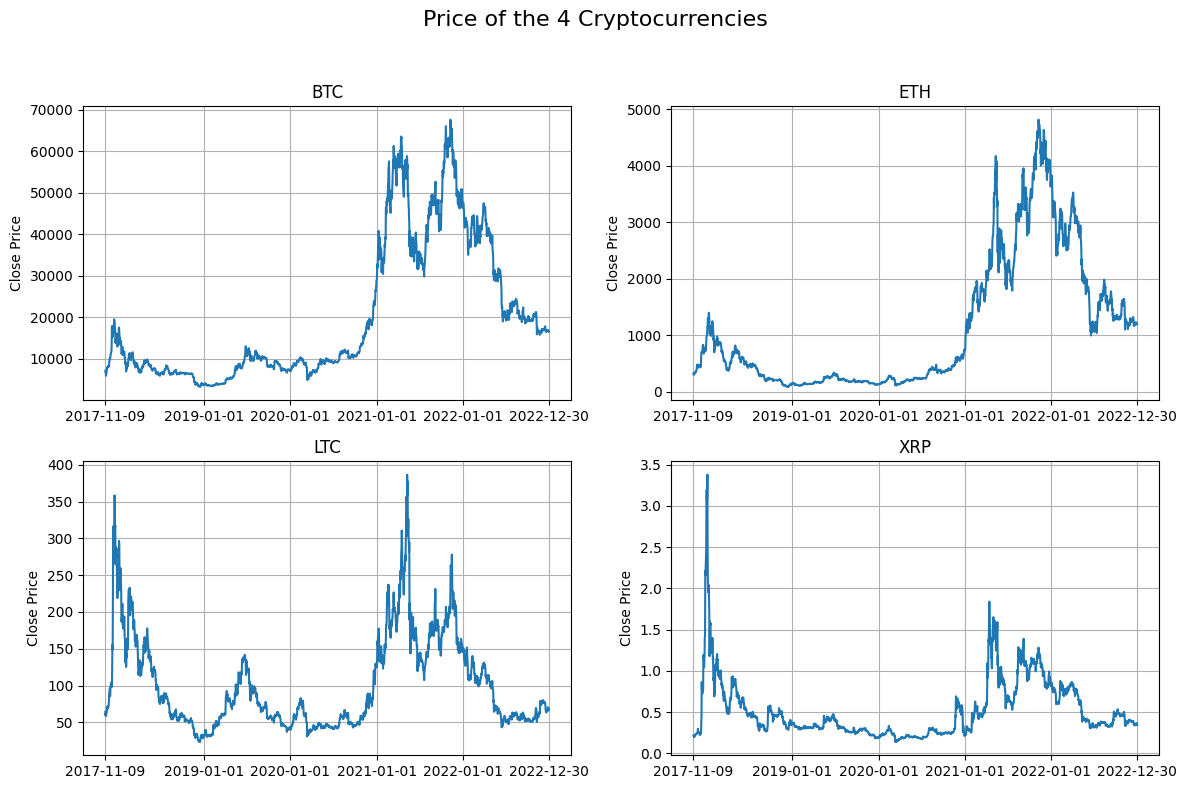

In [17]:
y=[]
for i in range(4):
    y.append(data_list[i][:,3])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
start_date = np.datetime64('2017-11-09')
dates = start_date + np.arange(len(y[0]))
name=["BTC","ETH","LTC","XRP"]
for i, ax in enumerate(axs.flat):
    ax.plot(dates, y[i])
    ax.set_title(name[i])
    ax.set_ylabel('Close Price')
    ax.grid(True)
    mid1 = np.datetime64('2019-01-01')
    mid2 = np.datetime64('2020-01-01')
    mid3 = np.datetime64('2021-01-01')
    mid4 = np.datetime64('2022-01-01')
    ax.set_xticks([dates[0], mid1, mid2, mid3, mid4, dates[-1]])
    ax.set_xticklabels([str(dates[0]), str(mid1), str(mid2), str(mid3), str(mid4),str(dates[-1])], rotation=0)

fig.suptitle('Price of the 4 Cryptocurrencies', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


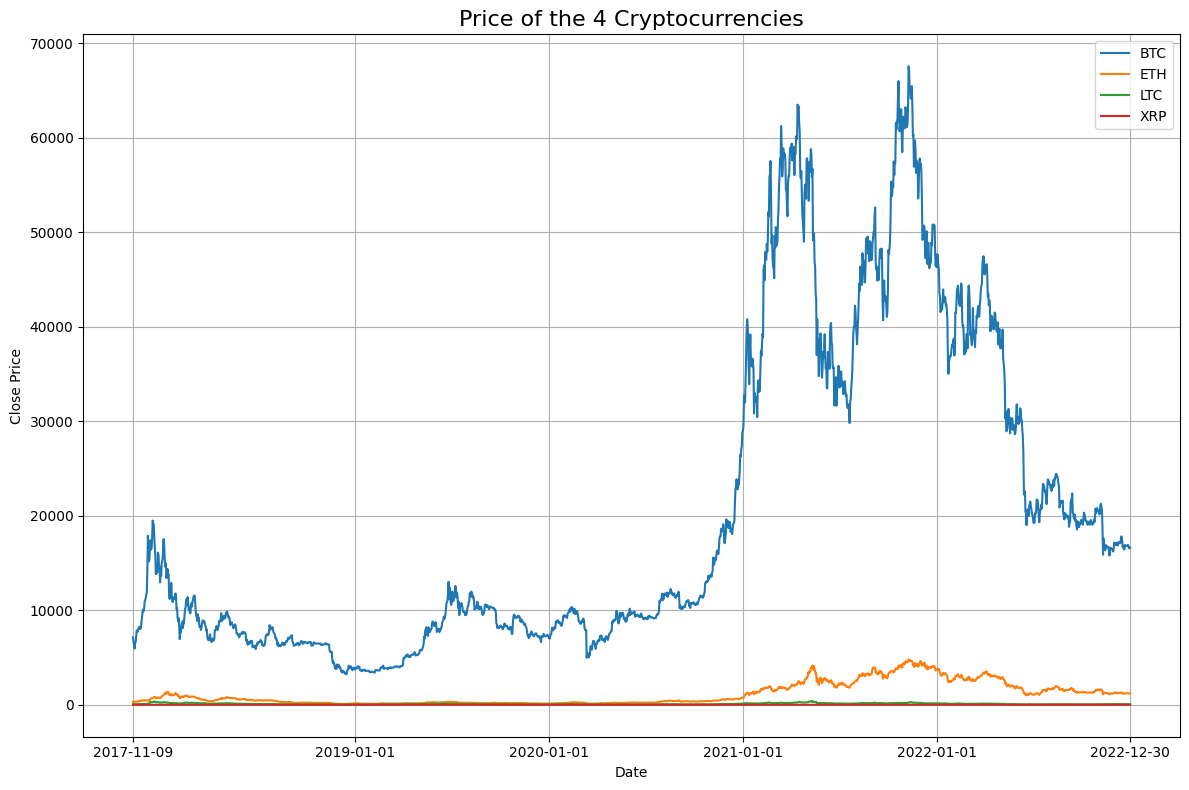

In [18]:
# Combine all four cryptocurrency price curves into one plot
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.plot(dates, y[i], label=name[i])

plt.title('Price of the 4 Cryptocurrencies', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()

# Set x-axis ticks
plt.xticks([dates[0], mid1, mid2, mid3, mid4, dates[-1]], 
           [str(dates[0]), str(mid1), str(mid2), str(mid3), str(mid4), str(dates[-1])], 
           rotation=0)

plt.tight_layout()
plt.show()